# Imports, data loading, and functions #

In [68]:
import os
import pandas as pd
import sqlite3
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from wordcloud import WordCloud
import random
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy import displacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pickle

## Import custom functions from 'regression_functions.py' ##
try:
    import importlib
    importlib.reload(fn)
except NameError: # It hasn't been imported yet
    import supervised_learning_functions as fn

## Import custom functions from 'regression_functions.py' ##
try:
    import importlib
    importlib.reload(mh)
except NameError: # It hasn't been imported yet
    import mh_functions as mh
    
data_directory = 'C:/Users/61407/mental-health-modelling/data'
db = 'mental_health.sqlite'

con = sqlite3.connect(os.path.join(data_directory, db))
cur = con.cursor()

sns.set()

# Modelling #

**1. Data splitting**
- We will only leave 10% out for final testing, since the number of samples is relatively low (but luckily we have balanced data, so we should still have enough samples in each class)

In [7]:
cleaned_data = np.load('cleaned_data_q1.npy',allow_pickle=True).item()
X_scaled = cleaned_data['X_scaled']
y = cleaned_data['y']

## Set up train test split ##
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

## Set up cross-validation split ##
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

**2. Define models to test**
- One simple linear classifier (i.e. LogisticRegression)
- One non-linear classifier (i.e. DecisionTrees)
- One complex ensemble method (i.e. XGBoost)

In [8]:
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression()

from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier()

from sklearn.ensemble import GradientBoostingClassifier
clf_gb = GradientBoostingClassifier()

**3. Define grid for randomized search CV (i.e. hyperparameter tuning)**

In [69]:
n_it = 500 #use the same number of search iterations for all models, for fair comparison

In [9]:
from sklearn.model_selection import RandomizedSearchCV

## Grid for LogisticRegression ##
grid_log = {'C':np.logspace(-2,0,101),
            'penalty':['l1','l2'],
            'solver':['saga']}
CV_log = RandomizedSearchCV(estimator=clf_log, param_distributions=grid_log, 
                            scoring='f1_micro', 
                            cv=kfold, n_iter=n_it,
                            random_state=42,
                            return_train_score=True,
                            error_score='raise')

## Grid for DecisionTree ##
grid_tree = {'max_depth':range(2,50),
          'min_samples_split':range(2,100),
          'criterion':['gini','entropy'],
          'min_impurity_decrease':np.logspace(-3,-1,101)}
CV_tree = RandomizedSearchCV(estimator=clf_tree, param_distributions=grid_tree, 
                              scoring='f1_micro',
                              cv=kfold, n_iter=n_it,
                              random_state=42,
                              return_train_score=True,
                              error_score='raise')

## Grid for gradient boosting ##
grid_gb = {'loss':['log_loss','exponential'],
            'learning_rate':np.logspace(-5,5, 101),
            'n_estimators':list(range(1,100)),
            'subsample':np.linspace(0,1,101)[1:],
            'criterion':['friedman_mse','squared_error'],
            'min_samples_split':range(2,100)}
CV_gb = RandomizedSearchCV(estimator=clf_gb, param_distributions=grid_gb, 
                              scoring='f1_micro',
                              cv=kfold, n_iter=n_it,
                              random_state=42,
                              return_train_score=True,
                              error_score='raise')

**4. Fit the models**

In [42]:
## Fit Logistic Regression model ##
try:
    with open('CV_log_q1.pkl', 'rb') as f:
        CV_log = pickle.load(f)
except FileNotFoundError:
    print('pickled CV log object not found so fitting the data')
    CV_log.fit(X_train.to_numpy(), y_train.to_numpy().reshape(-1,))
    best_log = CV_log.best_estimator_
    with open('CV_log_q1.pkl', 'wb') as file:
        pickle.dump(CV_log, file)
n_it_actual_log = CV_log.cv_results_['mean_fit_time'].shape[0] #the actual number of iterations that ended up running
    
## Fit Decision Tree model ##
try:
    with open('CV_tree_q1.pkl', 'rb') as f:
        CV_tree = pickle.load(f)
except FileNotFoundError:
    print('pickled CV tree object not found so fitting the data')
    CV_tree.fit(X_train.to_numpy(), y_train.to_numpy().reshape(-1,))
    best_tree = CV_tree.best_estimator_
    with open('CV_tree_q1.pkl', 'wb') as file:
        pickle.dump(CV_tree, file)
n_it_actual_tree = CV_tree.cv_results_['mean_fit_time'].shape[0] #the actual number of iterations that ended up running
    
# ## Fit Gradient Boosting model ##
try:
    with open('CV_gb_q1.pkl', 'rb') as f:
        CV_gb = pickle.load(f)
except FileNotFoundError:
    print('pickled CV gb object not found so fitting the data')
    CV_gb.fit(X_train.to_numpy(), y_train.to_numpy().reshape(-1,))
    best_gb = CV_gb.best_estimator_
    with open('CV_gb_q1.pkl', 'wb') as file:
        pickle.dump(CV_gb, file)
n_it_actual_gb = CV_gb.cv_results_['mean_fit_time'].shape[0] #the actual number of iterations that ended up running

**5.1 Logistic Regression: Visualize train-validate discrepancy for different values of hyperparameters**

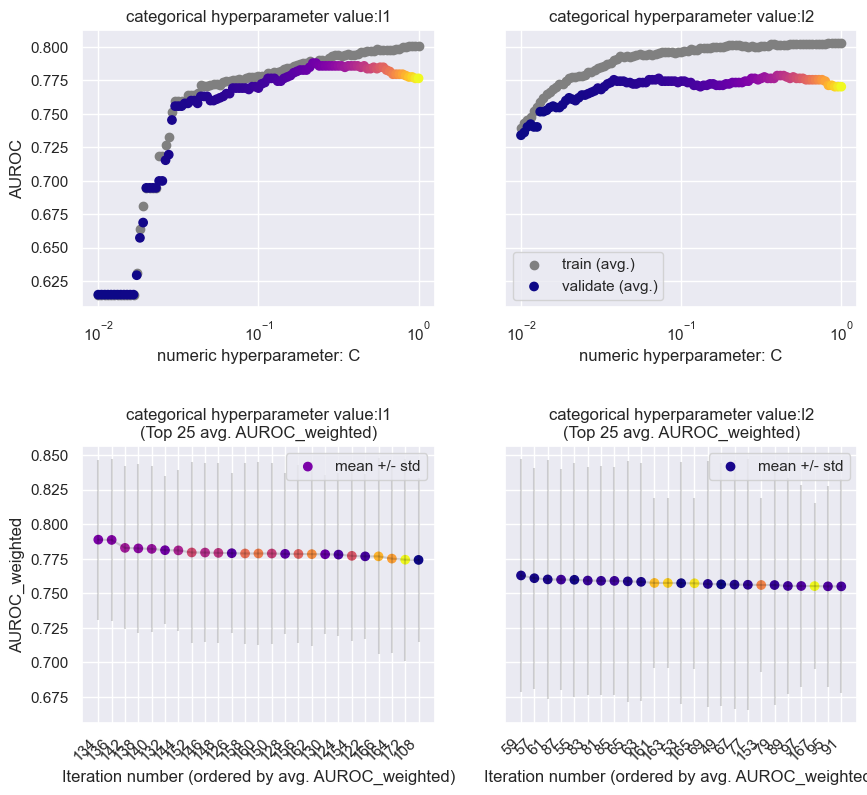

In [109]:
train_scores_log, validation_scores_log = mh.extract_CV_search_scores(CV_log, n_it_actual_log)
categorical_hyperparameters_log = {'penalty':['l1','l2']}
numerical_hyperparameter_log = 'C'
numerical_scale_log = 'log'
show_top = 25
mh.plot_CV_search(train_scores_log, validation_scores_log, categorical_hyperparameters_log, numerical_hyperparameter_log, numerical_scale_log, show_top)

**5.2 Decision Tree: Visualize train-validate discrepancy for different values of hyperparameters**

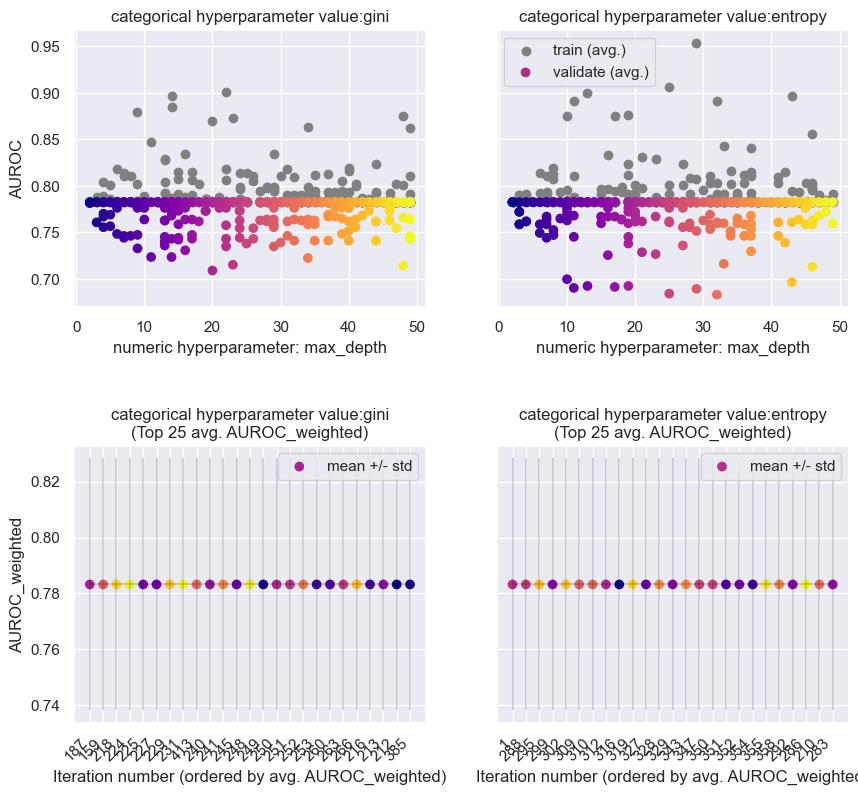

In [111]:
train_scores_tree, validation_scores_tree = mh.extract_CV_search_scores(CV_tree, n_it_actual_tree)
categorical_hyperparameters_tree = {'criterion':['gini','entropy']}
numerical_hyperparameter_tree = 'max_depth'
numerical_scale_tree = 'linear'
show_top = 25
mh.plot_CV_search(train_scores_tree, validation_scores_tree, categorical_hyperparameters_tree, numerical_hyperparameter_tree, numerical_scale_tree, show_top)

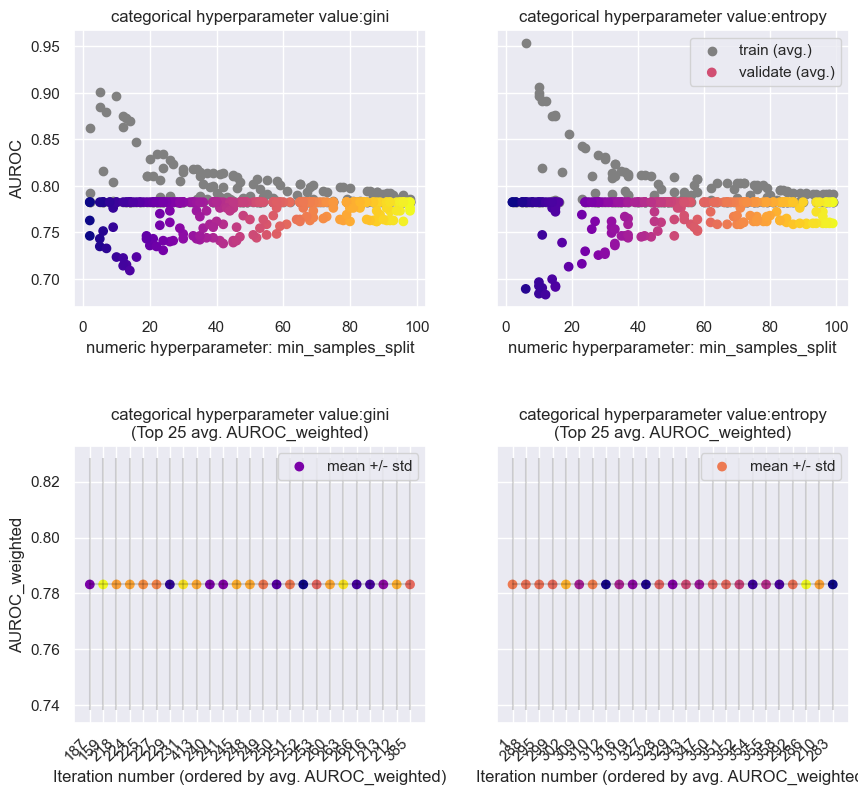

In [112]:
numerical_hyperparameter_tree = 'min_samples_split'
mh.plot_CV_search(train_scores_tree, validation_scores_tree, categorical_hyperparameters_tree, numerical_hyperparameter_tree, numerical_scale_tree, show_top)

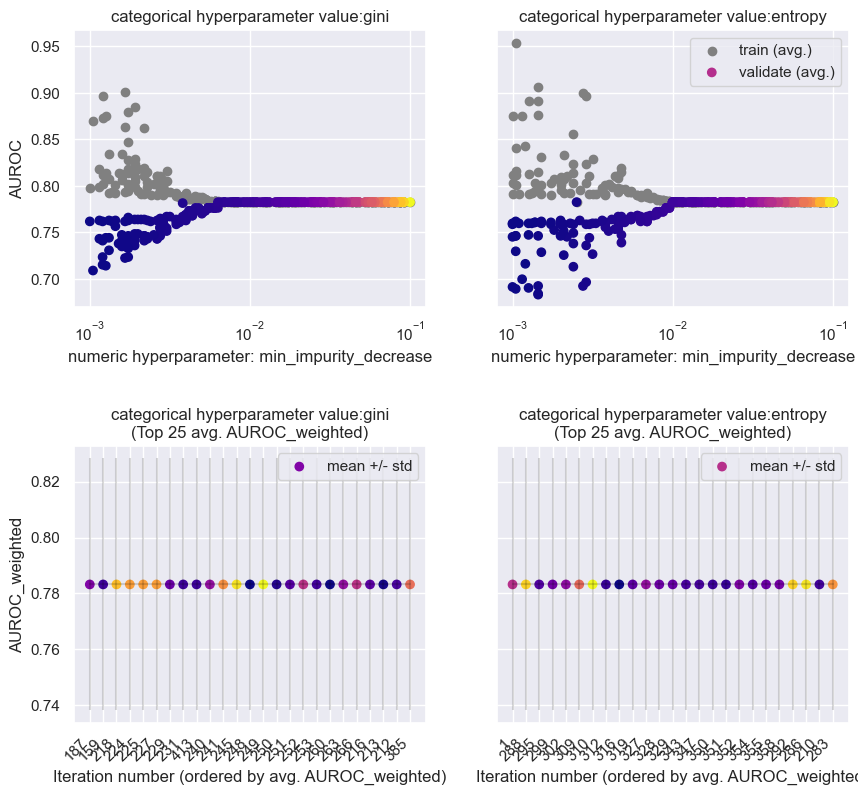

In [113]:
numerical_hyperparameter_tree = 'min_impurity_decrease'
numerical_scale_tree = 'log'
mh.plot_CV_search(train_scores_tree, validation_scores_tree, categorical_hyperparameters_tree, numerical_hyperparameter_tree, numerical_scale_tree, show_top)

**5.3 Gradient Boosting: Visualize train-validate discrepancy for different values of hyperparameters**

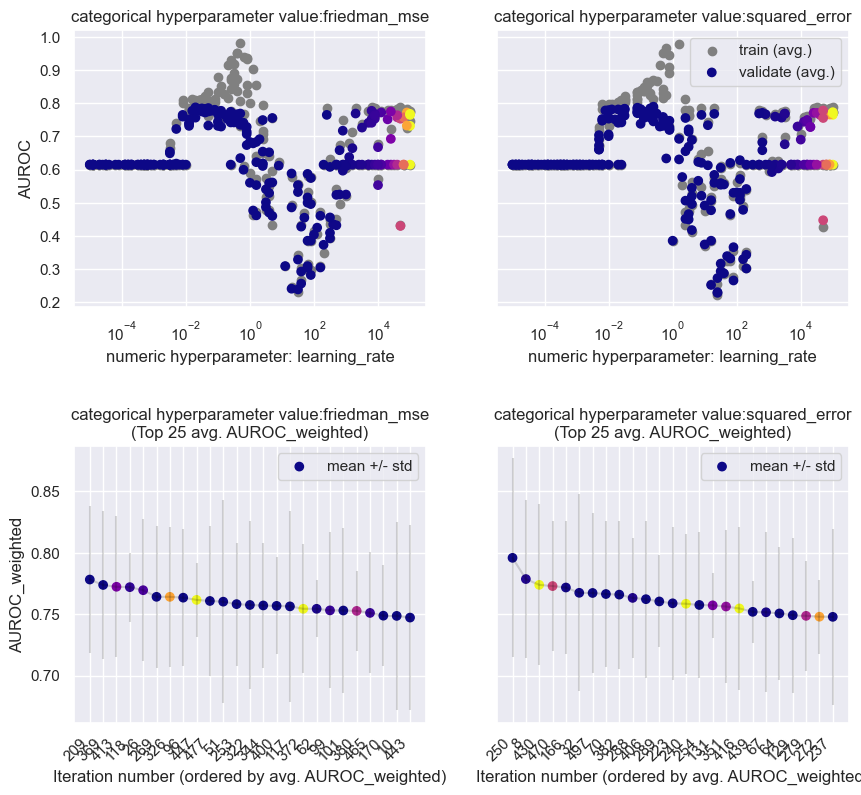

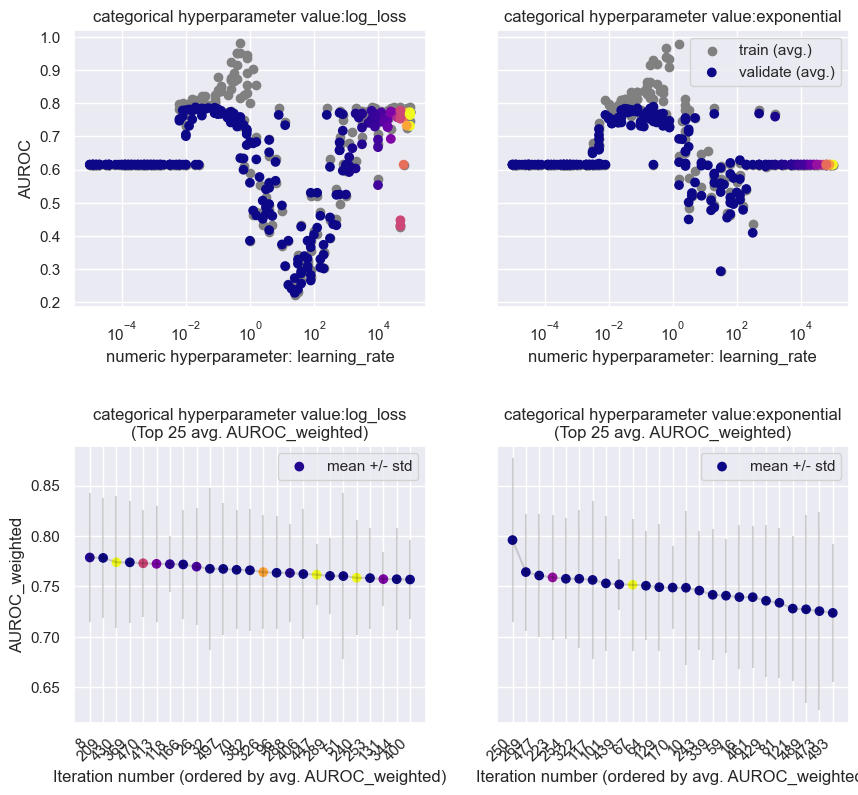

In [114]:
train_scores_gb, validation_scores_gb = mh.extract_CV_search_scores(CV_gb, n_it_actual_gb)
categorical_hyperparameters_gb = {'criterion': ['friedman_mse', 'squared_error'],
                                  'loss': ['log_loss', 'exponential']}
numerical_hyperparameter_gb = 'learning_rate'
numerical_scale_gb = 'log'
show_top = 25
mh.plot_CV_search(train_scores_gb, validation_scores_gb, categorical_hyperparameters_gb, numerical_hyperparameter_gb, numerical_scale_gb, show_top)

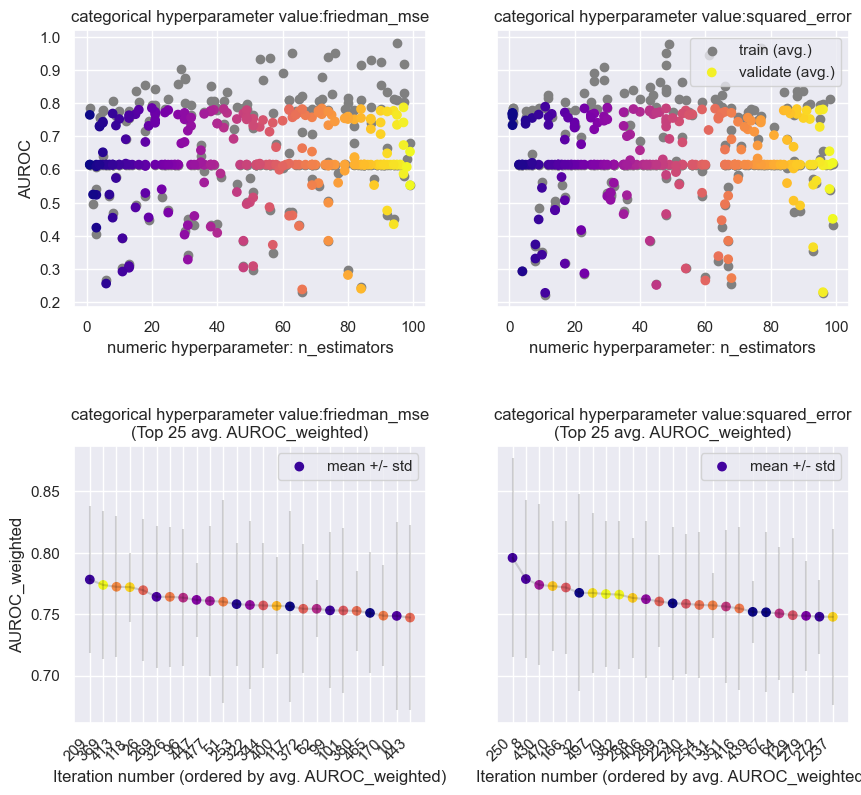

In [115]:
categorical_hyperparameters_gb = {'criterion': ['friedman_mse', 'squared_error']}
numerical_hyperparameter_gb = 'n_estimators'
numerical_scale_gb = 'linear'
mh.plot_CV_search(train_scores_gb, validation_scores_gb, categorical_hyperparameters_gb, numerical_hyperparameter_gb, numerical_scale_gb, show_top)

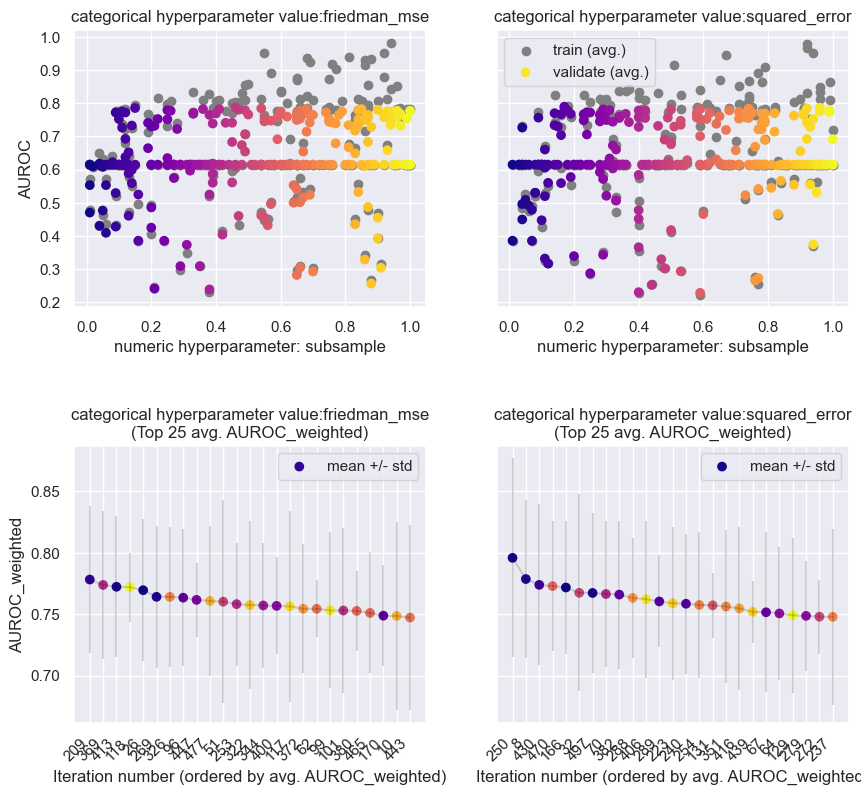

In [116]:
categorical_hyperparameters_gb = {'criterion': ['friedman_mse', 'squared_error']}
numerical_hyperparameter_gb = 'subsample'
numerical_scale_gb = 'linear'
mh.plot_CV_search(train_scores_gb, validation_scores_gb, categorical_hyperparameters_gb, numerical_hyperparameter_gb, numerical_scale_gb, show_top)

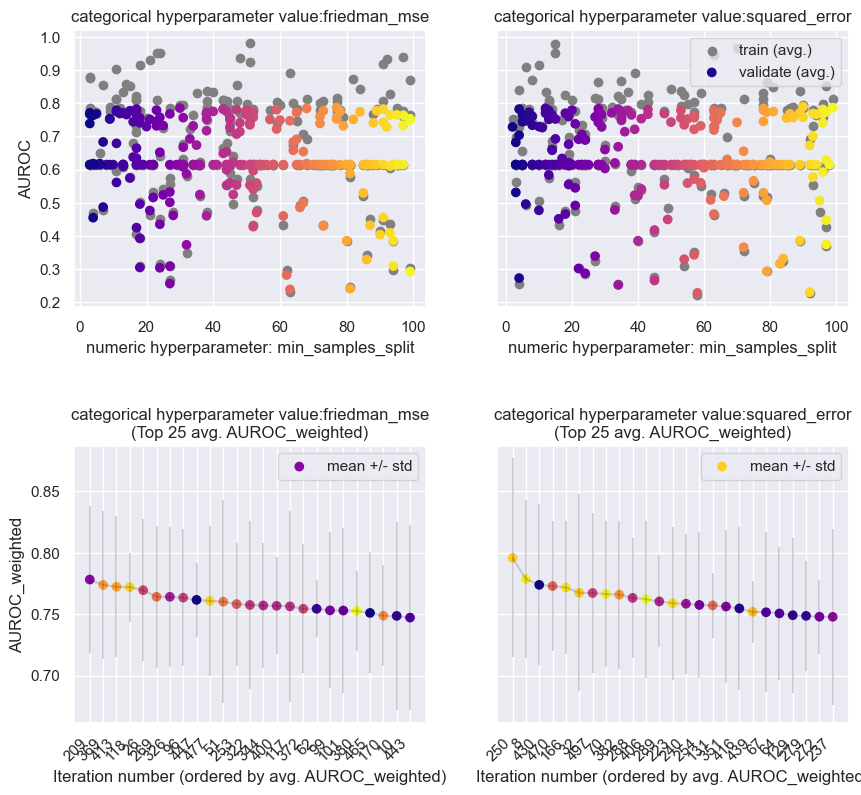

In [117]:
categorical_hyperparameters_gb = {'criterion': ['friedman_mse', 'squared_error']}
numerical_hyperparameter_gb = 'min_samples_split'
numerical_scale_gb = 'linear'
mh.plot_CV_search(train_scores_gb, validation_scores_gb, categorical_hyperparameters_gb, numerical_hyperparameter_gb, numerical_scale_gb, show_top)

**6.1 What does our best logistic regression model tell us?**

In [161]:
from sklearn import metrics

## Score Logistic Regression model ##
print("Best Logistic Regression model defined by sklearn (i.e. validation accuracy')")
testpred_log = best_log.predict(X_test)
print(f'Training AUROC: {metrics.roc_auc_score(y_test, testpred_log)}')
print(metrics.classification_report(y_test, testpred_log))
print('#'*80)
print()

print("Best Logistic Regression model defined by me (i.e. weighted validation accuracy') - iteration 134")
best_log_manual = LogisticRegression(**CV_log.cv_results_['params'][134])
best_log_manual.fit(X_train, y_train)
testpred_log_manual = best_log_manual.predict(X_test)
print(f'Training AUROC: {metrics.roc_auc_score(y_test, testpred_log_manual)}')
print(metrics.classification_report(y_test, testpred_log_manual))

Best Logistic Regression model defined by sklearn (i.e. validation accuracy')
Training AUROC: 0.7222222222222222
              precision    recall  f1-score   support

           0       0.77      0.78      0.77        63
           1       0.68      0.67      0.67        45

    accuracy                           0.73       108
   macro avg       0.72      0.72      0.72       108
weighted avg       0.73      0.73      0.73       108

################################################################################

Best Logistic Regression model defined by me (i.e. weighted validation accuracy') - iteration 134
Training AUROC: 0.7222222222222222
              precision    recall  f1-score   support

           0       0.77      0.78      0.77        63
           1       0.68      0.67      0.67        45

    accuracy                           0.73       108
   macro avg       0.72      0.72      0.72       108
weighted avg       0.73      0.73      0.73       108



C:\Users\61407\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\61407\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


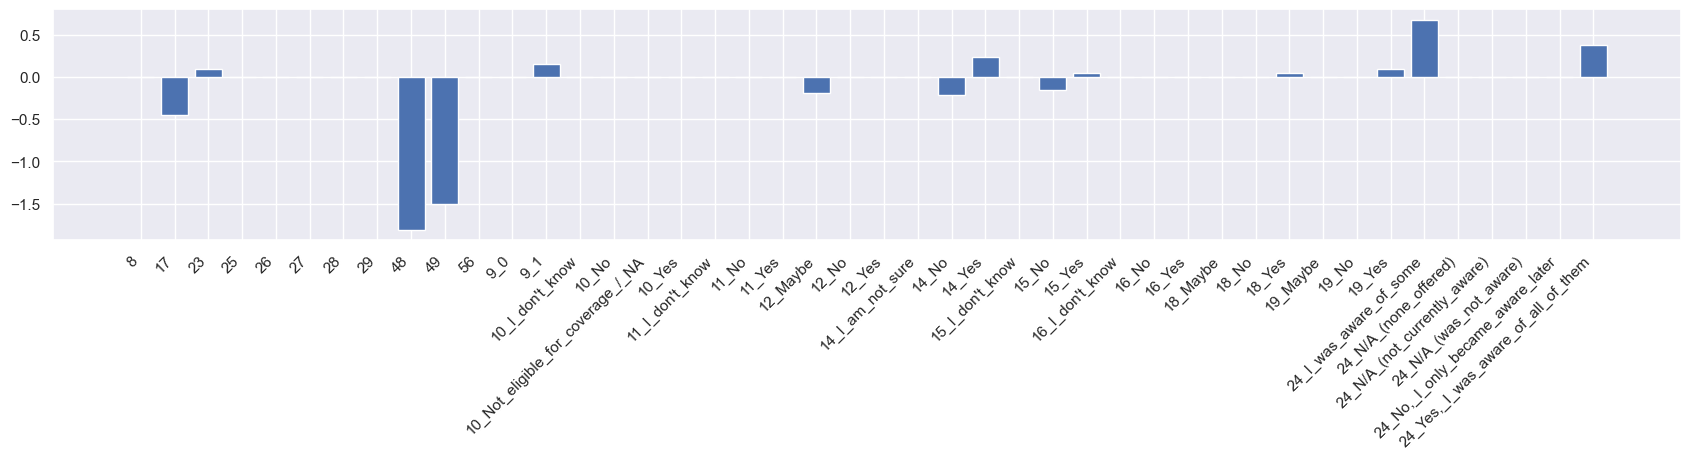

In [170]:
plt.figure(figsize=(21,3))
plt.bar(list(range(X_train.shape[1])), best_log_manual.coef_.reshape(-1))
plt.xticks(list(range(X_train.shape[1])), X_train.columns, rotation=45, ha='right');

In [53]:
for idx, q in pd.read_sql_query('SELECT questionid, questiontext FROM Question WHERE questionid IN (17,24,48,49)', con).iterrows():
    qid = q.questionid
    txt = q.questiontext
    print(f'{qid}. {txt}')

17. If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?
24. Were you aware of the options for mental health care provided by your previous employers?
48. If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?
49. If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?


**6.2 What does our best Decision Tree model tell us?**

In [162]:
## Score Decision Tree model ##
print("Best Decision Tree model defined by sklearn (i.e. validation accuracy')")
testpred_tree = best_tree.predict(X_test)
print(f'Training AUROC: {metrics.roc_auc_score(y_test, testpred_tree)}')
print(metrics.classification_report(y_test, testpred_tree))
print('#'*80)
print()

print("Best Decision Tree model defined by me (i.e. weighted validation accuracy') - iteration 187")
best_tree_manual = DecisionTreeClassifier(**CV_tree.cv_results_['params'][187])
best_tree_manual.fit(X_train, y_train)
testpred_tree_manual = best_tree_manual.predict(X_test)
print(f'Training AUROC: {metrics.roc_auc_score(y_test, testpred_tree_manual)}')
print(metrics.classification_report(y_test, testpred_tree_manual))

Best Decision Tree model defined by sklearn (i.e. validation accuracy')
Training AUROC: 0.7555555555555556
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        63
           1       0.70      0.73      0.72        45

    accuracy                           0.76       108
   macro avg       0.75      0.76      0.75       108
weighted avg       0.76      0.76      0.76       108

################################################################################

Best Decision Tree model defined by me (i.e. weighted validation accuracy') - iteration 187
Training AUROC: 0.7555555555555556
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        63
           1       0.70      0.73      0.72        45

    accuracy                           0.76       108
   macro avg       0.75      0.76      0.75       108
weighted avg       0.76      0.76      0.76       108



C:\Users\61407\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


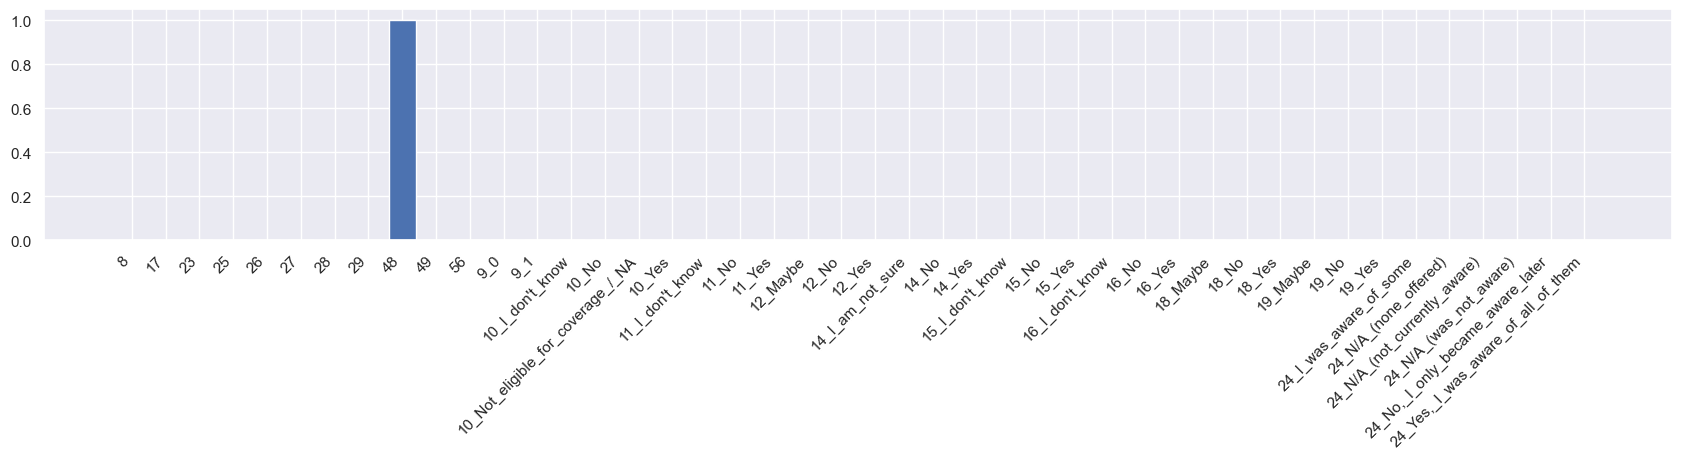

In [169]:
plt.figure(figsize=(21,3))
plt.bar(list(range(X_train.shape[1])), best_tree_manual.feature_importances_.reshape(-1))
plt.xticks(list(range(X_train.shape[1])), X_train.columns, rotation=45, ha='right');

**6.3 What does our best Gradient Boosting model tell us?**

In [167]:
## Score Gradient Boosting model ##
print("Best Gradient Boosting model defined by sklearn (i.e. validation accuracy')")
testpred_gb = best_gb.predict(X_test)
print(f'Training AUROC: {metrics.roc_auc_score(y_test, testpred_gb)}')
print(metrics.classification_report(y_test, testpred_gb))
print('#'*80)
print()

print("Best Gradient Boosting model model defined by me (i.e. weighted validation accuracy') - iteration 118")
best_gb_manual = GradientBoostingClassifier(**CV_gb.cv_results_['params'][118])
best_gb_manual.fit(X_train, y_train)
testpred_gb_manual = best_gb_manual.predict(X_test)
print(f'Training AUROC: {metrics.roc_auc_score(y_test, testpred_gb_manual)}')
print(metrics.classification_report(y_test, testpred_gb_manual))

Best Gradient Boosting model defined by sklearn (i.e. validation accuracy')
Training AUROC: 0.7555555555555556
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        63
           1       0.70      0.73      0.72        45

    accuracy                           0.76       108
   macro avg       0.75      0.76      0.75       108
weighted avg       0.76      0.76      0.76       108

################################################################################

Best Gradient Boosting model model defined by me (i.e. weighted validation accuracy') - iteration 118


C:\Users\61407\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\Users\61407\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training AUROC: 0.7555555555555556
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        63
           1       0.70      0.73      0.72        45

    accuracy                           0.76       108
   macro avg       0.75      0.76      0.75       108
weighted avg       0.76      0.76      0.76       108



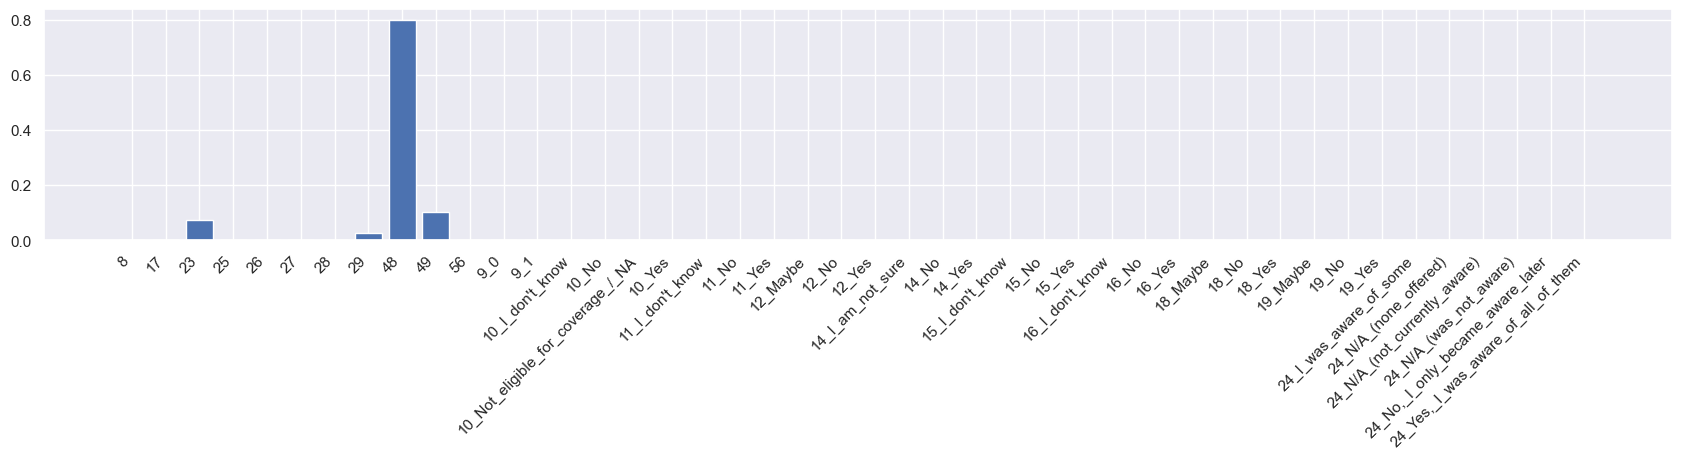

In [168]:
plt.figure(figsize=(21,3))
plt.bar(list(range(X_train.shape[1])), best_gb_manual.feature_importances_.reshape(-1))
plt.xticks(list(range(X_train.shape[1])), X_train.columns, rotation=45, ha='right');

**All the models perform slightly worse in predicting the minority class (i.e. label = 1; 'has sought treatment'), so I will attempt to use some class balancing techniques in the subsequent notebook ('Modelling_q1_classes_balanced')**